# Traitement des Données Distribuées

**Nathan BRY, Cédric VONIN**
<br/><br/>
*ENSAE 2021 - 2021*

## Libraries Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

import time
import warnings
warnings.filterwarnings('ignore')

sns.set()

## Dataset information

Le dataset est décrit dans le rapport PDF. Le véritable objectif de ce rapport étant d'illustrer les 2 concepts de parallélisme, nous ne décriverons que très brievement les données utilisées.

## Exploratory Data Analysis

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
data.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [5]:
data.info()

# No missing values
# We notice some object-type columns that will need to be converted to int/float-type columns in order to be used

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


### Feature Engineering

In [6]:
# We won't need the id column

data = data.drop(['id'],axis=1)

In [7]:
data.Gender.value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

In [8]:
# Let's map the Gender column so we can later use it, Male values will become 0 & Female values will become 1

data.Gender = data.Gender.map({'Male': 0, 'Female': 1})

In [9]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,0,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,0,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,0,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,1,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [10]:
data.Vehicle_Damage.value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [11]:
# Let's map the Vehicle_Damage column so we can later use it, Yes values will become 1 & No values will become 0

data.Vehicle_Damage = data.Vehicle_Damage.map({'No': 0, 'Yes': 1})

In [12]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,> 2 Years,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,> 2 Years,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In [13]:
data.Vehicle_Age.value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [14]:
# Let's map the Vehicle_Age column so we can later use it, "< 1 Year" values will become 0, 
# "1-2 Year" values will become 1 & "> 2 Years" will become 2

data.Vehicle_Age = data.Vehicle_Age.map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

In [15]:
data.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,0,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,0,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,0,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,1,29,1,41.0,1,0,0,27496.0,152.0,39,0


In [16]:
data.info()

# We no longer have object-type columns, all our columns can now be used to train Machine Leaarning algorithms

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 32.0 MB


### Data Analysis

In [17]:
# we separate our inputs (x) and target (y)

y = data.Response

x = data.drop(['Response'], axis = 1)

Number of No :  334399 (0.88%)
Number of Yes :  46710 (0.12%)


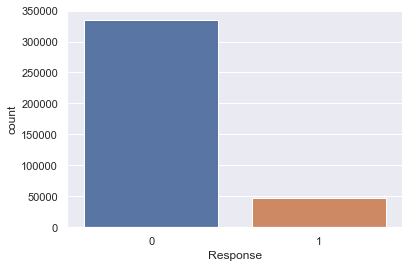

In [18]:
# We see here that the dataset is quite imbalanced: our positive class represents only 12% of the data. 
# This might be an issue later when training our models and making predictions

ax = sns.countplot(y,label="Count")    
N, Y = y.value_counts()
print('Number of No : ',N, '(' + str(round(N/(N+Y),2)) +'%)')
print('Number of Yes : ',Y, '(' + str(round(Y/(N+Y),2)) +'%)')

In [19]:
# Let's split our data in training and testing sets. 
# We use the stratify parameter to ensure we keep the same repartition of the Output variable

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state=0,stratify=y)

## Undersampling

One popular solution to deal with imbalanced datasets is Undersampling, which is about deleting some observations from the majority class to balance the data.

RandomUnderSampler (RUS) is one of the Undersampling techniques, that randomly picks some samples of the majority class and deletes them.

In [20]:
# Now that we have defined the RUS technique, let's use it to balance our data

In [21]:
y_train.value_counts()

0    267519
1     37368
Name: Response, dtype: int64

In [22]:
# We choose to balance the data until we have a 50-50 ratio between the 2 classes

rus = RandomUnderSampler(random_state=0)

x_train_res, y_train_res = rus.fit_sample(x_train, y_train)

In [23]:
y_train_res.value_counts()

1    37368
0    37368
Name: Response, dtype: int64

Une fois notre dataset undersamplé, nous avons choisi un modèle à implémenter afin d'illustrer les concepts de multithreading et multiprocessing.

## Multithreading

Afin de d'abord illustrer l'impact d'une stratégie de multithreading, nous avons donc entraîné un XGBoost en spécifiant à chaque fois le nombre de threads utilisés, avec des valeurs allant de 1 à 6. Pour chaque modèle, nous avons mesuré le temps (en secondes) pris pour le training.

In [29]:
# evaluate the effect of the number of threads
results = []
num_threads = [1, 2, 3, 4, 5, 6]
for n in num_threads:
    start = time.time()
    model = XGBClassifier(max_depth = 4, n_estimators= 300, nthread=n, verbosity=0, silent=True)
    model.fit(x_train_res, y_train_res)
    elapsed = time.time() - start
    print('Number of threads used:',n,'| Speed (seconds):', round(elapsed))
    print()
    results.append(elapsed)

Number of threads used: 1 | Speed (seconds): 16

Number of threads used: 2 | Speed (seconds): 10

Number of threads used: 3 | Speed (seconds): 7

Number of threads used: 4 | Speed (seconds): 6

Number of threads used: 5 | Speed (seconds): 6

Number of threads used: 6 | Speed (seconds): 6



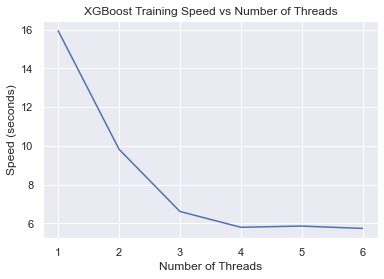

In [30]:
# plot results
plt.plot(num_threads, results)
plt.ylabel('Speed (seconds)')
plt.xlabel('Number of Threads')
plt.title('XGBoost Training Speed vs Number of Threads')
plt.show()

Bien que les vitesses de training soient relativement faibles (de l'ordre de la dizaine de secondes), on mesure assez bien l'impact du multithreading sur les durées de training. En effet, en passant de 1 à 6 threads utilisés on peut presque diviser par 3 le temps de training (de 16 à 6 secondes).

## Multiprocessing & Multithreading

In [24]:
# prepare GridSearchCV
param_grid = { 
    'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'n_estimators' : [100, 300, 500],
}


# Single Thread XGBoost, Single Job GridSearchCV
start = time.time()
model = XGBClassifier(random_state=0,verbosity=0,silent=True,nthread=1)
CV_xgb2 = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring='balanced_accuracy', n_jobs=1)
CV_xgb2.fit(x_train_res, y_train_res)
elapsed = time.time() - start
print("Single Thread XGBoost, Single Job GridSearchCV | Speed (seconds): %f" % (int(elapsed)))
print()

# Single Thread XGBoost, Parallel Job GridSearchCV
start = time.time()
model = XGBClassifier(random_state=0,verbosity=0,silent=True,nthread=1)
CV_xgb2 = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring='balanced_accuracy', n_jobs=-1)
CV_xgb2.fit(x_train_res, y_train_res)
elapsed = time.time() - start
print("Single Thread XGBoost, Parallel Job GridSearchCV | Speed (seconds): %f" % (int(elapsed)))
print()


# Parallel Thread XGBoost, Single Job GridSearchCV
start = time.time()
model = XGBClassifier(random_state=0,verbosity=0,silent=True,nthread=-1)
CV_xgb2 = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring='balanced_accuracy', n_jobs=1)
CV_xgb2.fit(x_train_res, y_train_res)
elapsed = time.time() - start
print("Parallel Thread XGBoost, Single Job GridSearchCV | Speed (seconds): %f" % (int(elapsed)))
print()


# Parallel Thread XGBoost, Parallel Job GridSearchCV
start = time.time()
model = XGBClassifier(random_state=0,verbosity=0,silent=True,nthread=-1)
CV_xgb2 = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5, scoring='balanced_accuracy', n_jobs=-1)
CV_xgb2.fit(x_train_res, y_train_res)
elapsed = time.time() - start
print("Parallel Thread XGBoost, Parallel Job GridSearchCV | Speed (seconds): %f" % (int(elapsed)))
print()

Single Thread XGBoost, Single Job GridSearchCV | Speed (seconds): 3658.000000

Single Thread XGBoost, Parallel Job GridSearchCV | Speed (seconds): 492.000000

Parallel Thread XGBoost, Single Job GridSearchCV | Speed (seconds): 1573.000000

Parallel Thread XGBoost, Parallel Job GridSearchCV | Speed (seconds): 584.000000



Voici les résultats observés. On constate à nouveau l’impact conséquent du multithreading et du multi-processing. En effet, si notre GridSearchCV prend à l’origine 1h pour tourner sans aucun parallélisme, on remarque que l’utilisation du multithreading pour notre modèle (comme dans l’exemple vu plus haut) permet de diviser par 2 le temps d’exécution. Cependant, le multiprocessing mis en place grâce à l’argument n_jobs = -1 de la fonction GridSearchCV, permettant d’utiliser tous les coeurs de notreprocesseur, a un impact encore plus important puisqu’il permet de diviser notre temps d’exécution par environ 6. En effet, lorsqu’on parallélise uniquement le GridSearch notre temps d’exécution est de seulement 8 minutes, et de 10 minutes lorsqu’on parallélise le modèle ET le GridSearch.